In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn.datasets
import cvxopt
import scipy.spatial
import itertools
import sklearn.svm

# Part 0: Loading The Dataset And Preprocessings

In [2]:
X_train, y_train = sklearn.datasets.load_svmlight_file('./datasets/satimage.scale.tr')
X_test, y_test = sklearn.datasets.load_svmlight_file('./datasets/satimage.scale.t')
X_validation, y_validation = sklearn.datasets.load_svmlight_file('./datasets/satimage.scale.val')

X_train = np.asarray(X_train.todense())
X_test = np.asarray(X_test.todense())
X_validation = np.asarray(X_validation.todense())

In [3]:
def do_preprocessing(X, y, old_lables, new_lables):
    X = X[((y == old_lables[0]) | (y == old_lables[1])).squeeze()]
    y = y[((y == old_lables[0]) | (y == old_lables[1])).squeeze()].reshape(-1, 1)
    y = np.where(
        y == old_lables[0],
        new_lables[0],
        np.where(y == old_lables[1], new_lables[1], y)
    )
    return X, y


X_train, y_train = do_preprocessing(X_train, y_train, (4, 6), (-1, 1))
X_test, y_test = do_preprocessing(X_test, y_test, (4, 6), (-1, 1))
X_validation, y_validation = do_preprocessing(
    X_validation, y_validation, (4, 6), (-1, 1)
)

In [4]:
def show_conf_matrix(y_true, y_hat):
    conf_mat = sklearn.metrics.confusion_matrix(y_true, y_hat)
    sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()
    plt.show()

def get_metrics(y_true, y_hat):
    acc = sklearn.metrics.accuracy_score(y_true, y_hat)
    balanced_acc = sklearn.metrics.balanced_accuracy_score(y_true, y_hat)
    return acc, balanced_acc  

# Part 1: Soft-Margin SVM

In [5]:
class SoftMarginSVM:
    def __init__(self, C=1):
        self.hyperparameters = {'C': C}
        self.weight = None
        self.bias = None

    def train(self, X_train, y_train, show_log=True):
        n = X_train.shape[0]

        K = X_train * y_train
        P = cvxopt.matrix(np.dot(K, K.T))
        q = cvxopt.matrix(-1 * np.ones(n))
        G = cvxopt.matrix(np.concatenate((-1 * np.identity(n), np.identity(n)), axis=0))
        h = cvxopt.matrix(
            np.concatenate((-1 * np.zeros(n), self.hyperparameters['C'] * np.ones(n)), axis=0)
        )
        A = cvxopt.matrix(1.0 * y_train, (1, n))
        b = cvxopt.matrix(0.0)

        if not show_log:
            cvxopt.solvers.options['show_progress'] = False
        alpha = np.ravel(cvxopt.solvers.qp(P, q, G, h, A, b)["x"]).reshape(-1, 1)

        sv_mask = np.where((alpha > 1e-10) & (alpha <= self.hyperparameters['C']))[0]
        self.weight = np.dot(K.T[:, sv_mask], alpha[sv_mask])

        margin_sv_mask = np.where((alpha > 1e-10) & (alpha < self.hyperparameters['C']))[0]
        self.bias = np.mean(
            y_train[margin_sv_mask] - np.dot(X_train[margin_sv_mask, :], self.weight)
        )

    def predict(self, X):
        y_hat = np.sign(np.dot(X, self.weight) + self.bias)
        y_hat[y_hat == 0] = 1
        return y_hat.squeeze()

In [6]:
sm_model = SoftMarginSVM()
sm_model.train(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -4.1814e+02 -2.1475e+03  1e+04  3e+00  6e-14
 1: -2.8867e+02 -1.4286e+03  2e+03  3e-01  6e-14
 2: -2.7710e+02 -4.7698e+02  2e+02  2e-02  5e-14
 3: -3.0754e+02 -3.9958e+02  1e+02  8e-03  5e-14
 4: -3.2114e+02 -3.7229e+02  5e+01  4e-03  5e-14
 5: -3.2791e+02 -3.6008e+02  3e+01  2e-03  5e-14
 6: -3.3417e+02 -3.4949e+02  2e+01  9e-04  5e-14
 7: -3.3732e+02 -3.4436e+02  7e+00  3e-04  5e-14
 8: -3.3870e+02 -3.4213e+02  3e+00  1e-04  5e-14
 9: -3.3959e+02 -3.4086e+02  1e+00  3e-05  5e-14
10: -3.4009e+02 -3.4022e+02  1e-01  9e-14  6e-14
11: -3.4015e+02 -3.4016e+02  8e-03  8e-15  5e-14
12: -3.4016e+02 -3.4016e+02  2e-04  2e-15  6e-14
Optimal solution found.


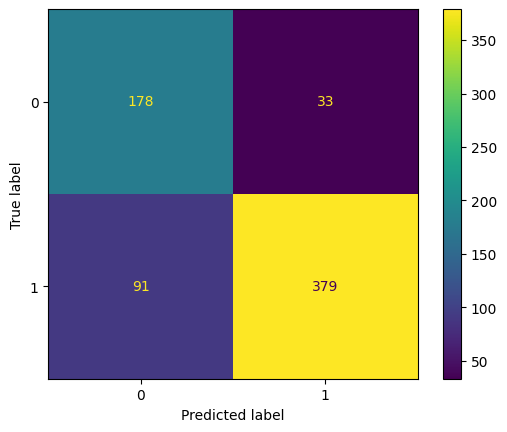

accuracy on test data = 0.8179148311306902
balanced accuracy on test data = 0.8249924372290007


In [7]:
y_hat = sm_model.predict(X_test)
show_conf_matrix(y_test, y_hat)
acc, balanced_acc = get_metrics(y_test, y_hat)
print(f'accuracy on test data = {acc}')
print(f'balanced accuracy on test data = {balanced_acc}')   

# Part 2: Soft-Margin SVM + RBF Kernel

In [8]:
class SoftMarginSVMKernel:
    def __init__(self, C=1, sigma=1):
        self.hyperparameters = {'sigma':sigma, 'C': C}
        self.weight = None
        self.bias = None
        self.sv_x = None
        self.sv_y = None
        self.sv_alpha = None

    def set_hyperparameters(self, new_hp):
        for key, value in new_hp.items():
            if key in self.hyperparameters:
                self.hyperparameters[key] = value

    # vectorized implementation of RBF kernel
    def calc_rbf_kernel_matrix(self, X1, X2):
        # this function calculates the distance of each row of X1 with each row of X2
        # exactly what we need :)
        distance_matrix = scipy.spatial.distance_matrix(X1, X2)
        return np.exp(-(distance_matrix**2) / ((self.hyperparameters['sigma']**2) * 2))

    def train(self, X_train, y_train, show_log=True):
        n = X_train.shape[0]

        kernel_matrix = self.calc_rbf_kernel_matrix(X_train, X_train)
        P = cvxopt.matrix(np.outer(y_train, y_train) * kernel_matrix)
        q = cvxopt.matrix(-1 * np.ones(n))
        G = cvxopt.matrix(np.concatenate((-1 * np.identity(n), np.identity(n)), axis=0))
        h = cvxopt.matrix(
            np.concatenate((-1 * np.zeros(n), self.hyperparameters['C'] * np.ones(n)), axis=0)
        )
        A = cvxopt.matrix(1.0 * y_train, (1, n))
        b = cvxopt.matrix(0.0)

        if not show_log:
            cvxopt.solvers.options['show_progress'] = False
        alpha = np.ravel(cvxopt.solvers.qp(P, q, G, h, A, b)["x"]).reshape(-1, 1)

        sv_mask = np.where((alpha > 1e-10) & (alpha <= self.hyperparameters['C']))[0]
        self.sv_x = X_train[sv_mask, :]
        self.sv_y = y_train[sv_mask]
        self.sv_alpha = alpha[sv_mask]

        margin_sv_mask = np.where((alpha > 1e-10) & (alpha < self.hyperparameters['C']))[0]
        first_margin_sv_x = X_train[margin_sv_mask, :][0].reshape(1, -1)
        first_margin_sv_y = y_train[margin_sv_mask][0]

        self.bias = first_margin_sv_y
        self.bias -= (
            np.dot(
                self.calc_rbf_kernel_matrix(self.sv_x, first_margin_sv_x).T,
                (self.sv_y * self.sv_alpha),
            )
        ).squeeze()

    def predict(self, X):
        y_hat = np.sign(
            np.dot(
                self.calc_rbf_kernel_matrix(X, self.sv_x), (self.sv_y * self.sv_alpha)
            ).squeeze()
        )
        y_hat[y_hat == 0] = 1
        return y_hat

## Fine Tuning Sigma

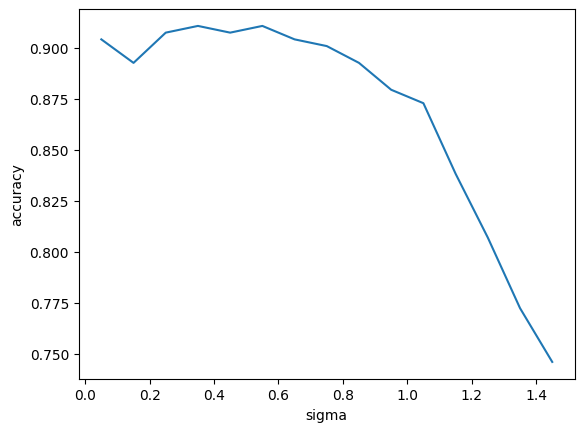

best sigma based on validatoin set is: 0.35000000000000003


In [9]:
sm_svm_kernel_model = SoftMarginSVMKernel()

acc_list = []
start, end, step_size = 0.05, 1.5, 0.1
sigma_list = np.arange(start, end, step_size)
for sigma in sigma_list:
    sm_svm_kernel_model.set_hyperparameters({'sigma': sigma})
    sm_svm_kernel_model.train(X_train, y_train, show_log=False)
    
    y_val_hat = sm_svm_kernel_model.predict(X_validation)
    acc_list.append(get_metrics(y_validation, y_val_hat)[0])

plt.plot(sigma_list, acc_list)
plt.xlabel('sigma')
plt.ylabel('accuracy')
plt.show()

best_sigma = sigma_list[np.argmax(acc_list)]
print(f'best sigma based on validatoin set is: {best_sigma}')

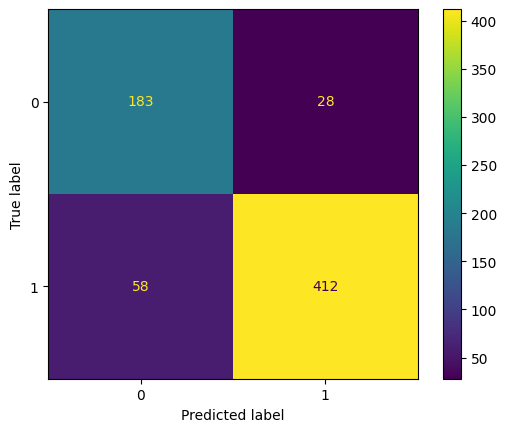

accuracy on test data = 0.8737151248164464
balanced accuracy on test data = 0.8719471614399517


In [10]:
sm_svm_kernel_model.set_hyperparameters({'sigma': best_sigma})
sm_svm_kernel_model.train(X_train, y_train, show_log=False)

y_test_hat = sm_svm_kernel_model.predict(X_test)
show_conf_matrix(y_test, y_test_hat)
acc, balanced_acc = get_metrics(y_test, y_test_hat)
print(f'accuracy on test data = {acc}')
print(f'balanced accuracy on test data = {balanced_acc}')  

# Part 3: Using Predefined SVM (Multiclass Classification)

In [11]:
X_train, y_train = sklearn.datasets.load_svmlight_file('./datasets/satimage.scale.tr')
X_test, y_test = sklearn.datasets.load_svmlight_file('./datasets/satimage.scale.t')
X_validation, y_validation = sklearn.datasets.load_svmlight_file('./datasets/satimage.scale.val')

X_train = np.asarray(X_train.todense())
X_test = np.asarray(X_test.todense())
X_validation = np.asarray(X_validation.todense())

In [12]:
kernel_dict = {'linear': None, 'sigmoid': None, 'poly': None, 'rbf': None}
for k in kernel_dict:
    model = sklearn.svm.SVC(kernel=k)
    model = model.fit(X_train, y_train)
    y_val_hat = model.predict(X_validation)
    acc, _ = get_metrics(y_validation, y_val_hat)
    kernel_dict[k] = acc

for k, acc in kernel_dict.items():
    print(f'kernel: {k} ---> acc = {acc}')

best_kernel_name, _ = max(kernel_dict.items(), key=lambda x: x[1])
print(f'kernel {best_kernel_name} is selected')

kernel: linear ---> acc = 0.8489857250187829
kernel: sigmoid ---> acc = 0.7460555972952667
kernel: poly ---> acc = 0.8302028549962435
kernel: rbf ---> acc = 0.8625093914350113
kernel rbf is selected


## Hyperparameter Fine Tuning (Jointly)

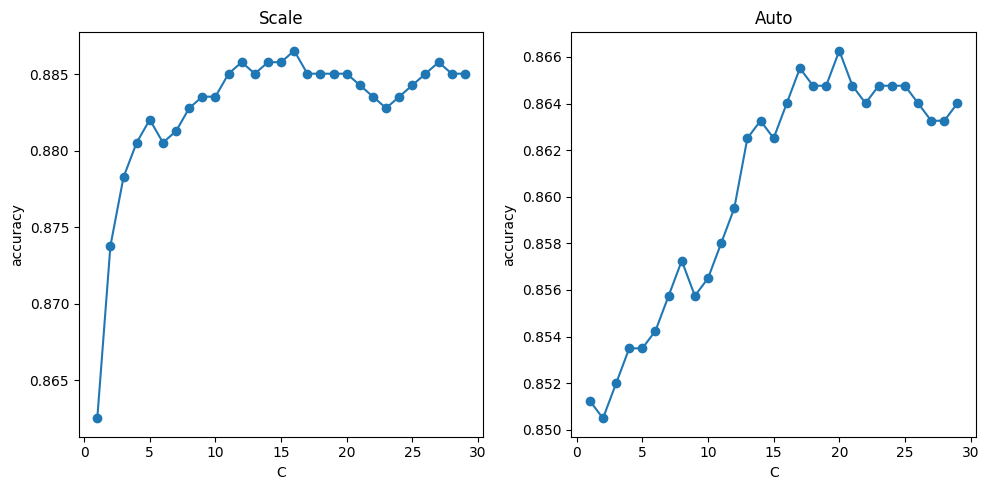

(C = 16, gamma:"scale") gives the best accuracy which is 0.8865514650638617


In [13]:
hp_dict = {}
start, end, step_size = 1, 30, 1
C_list = np.arange(start, end, step_size)
for C in C_list:
    for gamma in ('scale', 'auto'):
        model = sklearn.svm.SVC(kernel='rbf', C=C, gamma=gamma)
        model = model.fit(X_train, y_train)
        y_val_hat = model.predict(X_validation)
        acc, _ = get_metrics(y_validation, y_val_hat)
        hp_dict[(C, gamma)] = acc

# plotting the results
scale_data = {key[0]: val for key, val in hp_dict.items() if key[1] == 'scale'}
auto_data = {key[0]: val for key, val in hp_dict.items() if key[1] == 'auto'}

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(list(scale_data.keys()), list(scale_data.values()), marker='o')
axes[0].set_title('Scale')
axes[0].set_xlabel('C')
axes[0].set_ylabel('accuracy')

axes[1].plot(list(auto_data.keys()), list(auto_data.values()), marker='o')
axes[1].set_title('Auto')
axes[1].set_xlabel('C')
axes[1].set_ylabel('accuracy')

plt.tight_layout()
plt.show()

# showing the best results
(best_C, best_gamma), acc = max(hp_dict.items(), key=lambda x: x[1])
print(f'(C = {best_C}, gamma:"{best_gamma}") gives the best accuracy which is {acc}')

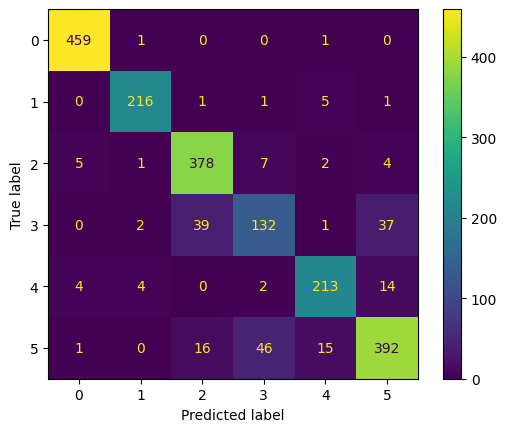

accuracy on test data = 0.895
balanced accuracy on test data = 0.8784095874824313


In [14]:
model = sklearn.svm.SVC(kernel=best_kernel_name, C=best_C, gamma=best_gamma)
model = model.fit(X_train, y_train)

y_test_hat = model.predict(X_test)
show_conf_matrix(y_test, y_test_hat)
acc, balanced_acc = get_metrics(y_test, y_test_hat)
print(f'accuracy on test data = {acc}')
print(f'balanced accuracy on test data = {balanced_acc}')
 

# Part 4: Three Class Classification With Soft-Margin SVM

Here we use the previous binary models implemented in part 2 in order to implement a three class SVM. (we need 3 binary models for this task)

The method is to separate the training dataset into two-class subsets and give it to our binary models to train on.

At inference time we give the input to all three binary models and then we return the majority as our final answer.

In [15]:
X_train, y_train = sklearn.datasets.load_svmlight_file('./datasets/satimage.scale.tr')
X_test, y_test = sklearn.datasets.load_svmlight_file('./datasets/satimage.scale.t')
X_validation, y_validation = sklearn.datasets.load_svmlight_file('./datasets/satimage.scale.val')

X_train = np.asarray(X_train.todense())
X_test = np.asarray(X_test.todense())
X_validation = np.asarray(X_validation.todense())

here I chose classes 2, 4, 6 randomly to classify them

In [16]:
def do_three_class_preprocessing(X, y, old_labels, new_labels):
    X = X[
        (y == old_labels[0]) | (y == old_labels[1]) | (y == old_labels[2])
    ]
    y = y[
        (y == old_labels[0])
        | (y == old_labels[1])
        | (y == old_labels[2])
    ].reshape(-1, 1)
    y = np.where(
        y == old_labels[0],
        new_labels[0],
        np.where(
            y == old_labels[1],
            new_labels[1],
            np.where(y == old_labels[2], new_labels[2], y)
        )
    )
    return X, y

selected_labels = (2, 4, 6)

X_train, y_train = do_three_class_preprocessing(X_train, y_train, selected_labels, (1,2,3))
X_test, y_test = do_three_class_preprocessing(X_test, y_test, selected_labels, (1,2,3))
X_validation, y_validation = do_three_class_preprocessing(
    X_validation, y_validation, selected_labels, (1,2,3)
)


In [17]:
class ThreeClassSoftSVMKernel:
    def __init__(self, C=1, sigma=1):
        self.binary_models = dict(
            zip(
                [
                    binary_labels
                    for binary_labels in itertools.combinations((1, 2, 3), 2)
                ],
                [SoftMarginSVMKernel(C=C, sigma=sigma) for _ in range(3)],
            )
        )

    def train(self, X_train, y_train, show_log=False):
        for binary_labels in itertools.combinations((1, 2, 3), 2):
            X_train_binary, y_train_binary = do_preprocessing(
                X_train, y_train, binary_labels, (-1, 1)
            )
            self.binary_models[binary_labels].train(
                X_train_binary, y_train_binary, show_log=show_log
            )

    def predict(self, X):
        y_hat_mat = []
        for binary_labels in itertools.combinations((1, 2, 3), 2):
            y_hat = self.binary_models[binary_labels].predict(X)

            new_labels = tuple(element + 1 for element in binary_labels)
            y_hat = np.where(
                    y_hat == -1,
                    new_labels[0],
                    np.where(y_hat == 1, new_labels[1], y_hat)
                )
            y_hat -= 1
            y_hat_mat.append(y_hat)

        y_hat_mat = np.stack(y_hat_mat, axis=-1).astype(int)
        
        # the following code applies majority on the columns of the matrix
        return np.apply_along_axis(
            lambda x: np.bincount(x).argmax(), axis=-1, arr=y_hat_mat)

## Fine Tuning Sigma

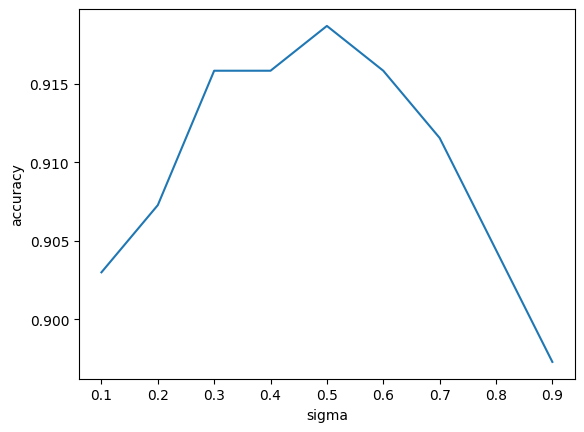

best sigma based on validatoin set is: 0.5


In [18]:
acc_list = []
start, end, step_size = 0.1, 1, 0.1
sigma_list = np.arange(start, end, step_size)
for sigma in sigma_list:
    model = ThreeClassSoftSVMKernel(sigma=sigma)
    model.train(X_train, y_train)
    
    y_val_hat = model.predict(X_validation)
    acc_list.append(get_metrics(y_validation, y_val_hat)[0])

plt.plot(sigma_list, acc_list)
plt.xlabel('sigma')
plt.ylabel('accuracy')
plt.show()

best_sigma = sigma_list[np.argmax(acc_list)]
print(f'best sigma based on validatoin set is: {best_sigma}')

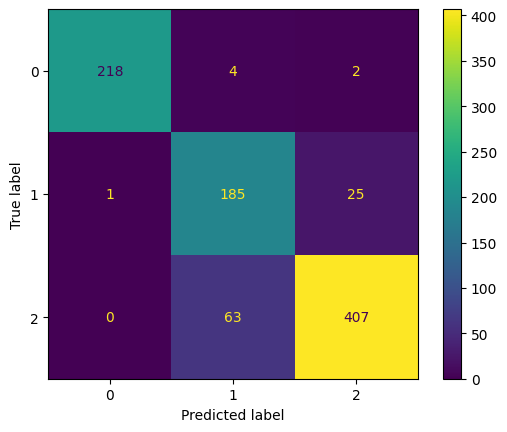

accuracy on test data = 0.8950276243093923
balanced accuracy on test data = 0.9053163279025435


In [19]:
model = ThreeClassSoftSVMKernel(sigma=best_sigma)
model.train(X_train, y_train)

y_test_hat = model.predict(X_test)
show_conf_matrix(y_test, y_test_hat)
acc, balanced_acc = get_metrics(y_test, y_test_hat)
print(f'accuracy on test data = {acc}')
print(f'balanced accuracy on test data = {balanced_acc}')